# JWST retrieval workflow with `SpectralModel`

Written by [Doriann Blain](mailto:doriann.blain@gmail.com).

The goal of this notebook is to go through a typical low-resolution retrieval workflow with `SpectralModel`. More details on the `SpectralModel` object are available in the [SpectralModel notebook](./spectral_model.html). More details on the `retrieval` module can be found  in the [retrieval tutorial notebook](./retrieval_basic.html). For the equivalent of this workflow using `Radtrans`, see the  [retrieval with multiple datasets notebook](./retrieval_multiple_data.html).

<div class="alert alert-info">

For retrievals at high resoltion, see the [retrieval at high resolution notebook](./retrieval_spectral_model.html). The `SpectralModel` retrieval workflows at high and low resolution are very similar. Most of the steps are common between the two.
</div>

We make some useful imports below.

In [1]:
import copy
import os

import matplotlib.pyplot as plt
import numpy as np

import petitRADTRANS.physical_constants as cst
from petitRADTRANS.plotlib import plot_result_corner
from petitRADTRANS.retrieval.retrieval import Retrieval
from petitRADTRANS.spectral_model import SpectralModel

## Loading data

The first step of any retrieval is to load the data to be retrieved. In a real case, this would be done with something in the line of:

```python
# Load the wavelengths, spectra, and uncertainties (errors)
data_wavelengths, data, data_uncertainties = load('my_data_file')
```

With the `load` function replaced with the steps necessary to load the data, that can be contained in one (or several) `'my_data_file'` file(s).

In this example, we will analyze JWST data from a transit of WASP-39 b. Let's first localize the data:

In [2]:
path_to_data = os.path.join('./', 'retrievals', 'transmission', 'observations', 'JWST')

Let's now load data from the JWST NIRSpec PRISM:

In [3]:
nirspec_data_file = os.path.join(path_to_data, 'WASP39b_nirspec_prism.txt')

nirspec_wavelengths, nirspec_wavelength_bin_widths, nirspec_data, nirspec_uncertainties = np.loadtxt(nirspec_data_file).T

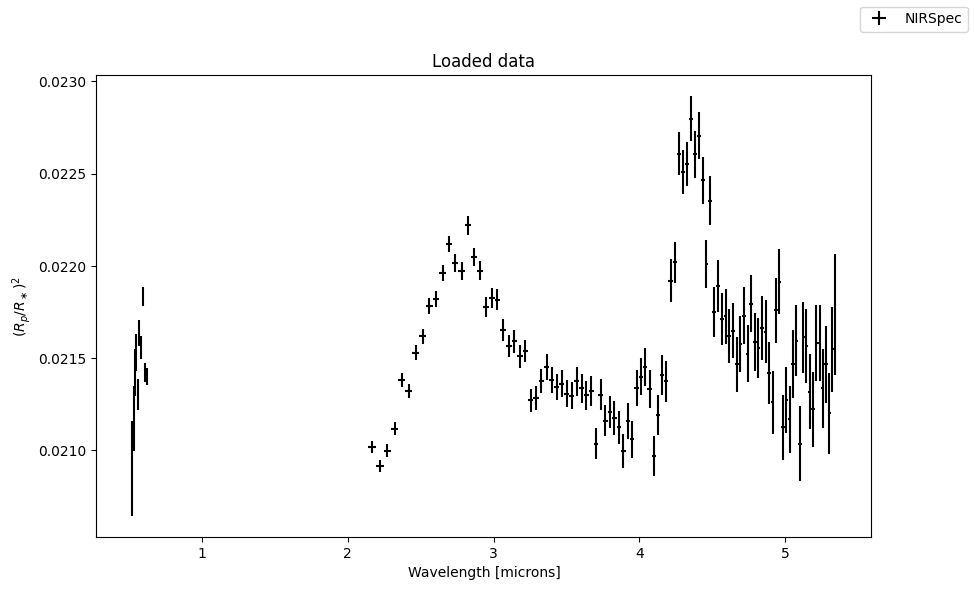

In [4]:
# Plot the data
fig, ax = plt.subplots(figsize = (10,6))

ax.errorbar(nirspec_wavelengths, nirspec_data, xerr=nirspec_wavelength_bin_widths, yerr=nirspec_uncertainties, ls='', color='k', label='NIRSpec')
ax.set_xlabel('Wavelength [microns]')
ax.set_ylabel(r'$(R_p/R_\ast)^2$')
ax.set_title('Loaded data')
fig.legend()

## Optional: loading a `Planet`

It can be convenient to use the [Planet object](./planet.html) to get the parameters we need. Note that this is not required.

In [5]:
from petitRADTRANS.planet import Planet

planet = Planet.get('WASP-39 b')

## Initializing the forward model

Let's first make the forward model for the NIRSpec data. We will use a simple model with an isothermal temperature profile, constant mass fractions, and a simple fractioned cloud layer. 

Since the data have a resolving power of ~100, we will bin-down the opacities to resolving power of 300 in order to gain speed and memory. To do this, we simply need to add `.R300` to the opacities names.

<div class="alert alert-info">
    
Values given to retrieved parameters at instantiation will not affect the retrieval.
</div>

In [6]:
forward_model_nirspec = SpectralModel(
    # Radtrans parameters
    pressures=np.logspace(-6, 2, 100),
    line_species=[
        'CH4.R300',
        'CO-NatAbund.R300',
        'CO2.R300', 
        'H2O__POKAZATEL.R300',
        'SO2.R300'
    ],
    rayleigh_species=['H2', 'He'],
    gas_continuum_contributors=['H2-H2', 'H2-He'],
    # SpectralModel parameters
    # Planet parameters
    planet_radius=planet.radius,
    reference_gravity=planet.reference_gravity,
    reference_pressure=1e-2,
    star_radius=planet.star_radius,
    # Temperature profile parameters
    temperature_profile_mode='isothermal',
    temperature=planet.equilibrium_temperature,
    # Cloud parameters
    opaque_cloud_top_pressure=1e2,
    cloud_fraction=1.0,
    # Mass fractions
    use_equilibrium_chemistry=False,
    imposed_mass_fractions={
        'CH4.R300': 1e-6,
        'CO-NatAbund.R300': 1e-2,
        'CO2.R300': 1e-4,
        'H2O__POKAZATEL.R300': 1e-3,
        'SO2.R300': 1e-4
    },
    filling_species={
        'H2': 37,
        'He': 12
    },
    # Observation parameters
    rebinned_wavelengths=nirspec_wavelengths * 1e-4,  # (cm)
    bin_widths=nirspec_wavelength_bin_widths * 1e-4,
    rebin_range_margin_power=1,  # increase the margin of the optimal wavelengths boundaries by 100 nm (1e-1 * 1 um)
    convolve_resolving_power=100  # used for the convolution
)

Loading Radtrans opacities...
 Loading line opacities of species 'CH4.R300' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/CH4/12C-1H4/12C-1H4__YT34to10.R300_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CO-NatAbund.R300' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/CO/C-O-NatAbund/C-O-NatAbund__HITEMP.R300_0.1-250mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CO2.R300' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/CO2/12C-16O2/12C-16O2__UCL-4000.R300_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'H2O__POKAZATEL.R300' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/H2O/1H2-16O/1H2-16O__POKAZATEL.R300_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'SO2.R300' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/SO2/32S-

## Defining the retrieved parameters

Let's define the parameters we will retrieve. We will retrieve the temperature, the abundance of our line species, the pressure of the cloud, as well as the cloud fraction. We will use uniform prior in all cases. In the `SpectralModel` workflow, we only need to sepcify which of our `model_parameters` we would like to retrieve, and how.

<div class="alert alert-info">
    
**Any** model parameter can be retrieved in this way. It could be interesting to retrieve, e.g., `convolve_resolving_power` or `reference_gravity`. We could also use a more complex temperature profile or cloud model. For this example, we will limit the number of retrieved parameters. But in a real case, you just need to add the name and prior parameters in the `retrieved_parameters` dictionary.
</div>

In [7]:
retrieved_parameters = {
    'temperature': {
        'prior_parameters': [100, 4000],  # (K)
        'prior_type': 'uniform',
        'figure_title': r'T',
        'figure_label': r'T (K)'
    },
    'planet_radius': {
       'prior_parameters': np.array([0.8, 1.6]) * cst.r_jup,  # (s)
       'prior_type': 'uniform',
       'figure_title': r'$R_p$',
       'figure_label': r'$R_p$)'
    },
    'CH4.R300': {
        'prior_parameters': [-12, 0],  # (MMR)
        'prior_type': 'uniform',
        'figure_title': r'[CH4]',
        'figure_label': r'$\log_{10}$(MMR) CH4'
    },
    'CO-NatAbund.R300': {
        'prior_parameters': [-12, 0],  # (MMR)
        'prior_type': 'uniform',
        'figure_title': r'[CO]',
        'figure_label': r'$\log_{10}$(MMR) CO'
    },
    'CO2.R300': {
        'prior_parameters': [-12, 0],  # (MMR)
        'prior_type': 'uniform',
        'figure_title': r'[CO$_2$]',
        'figure_label': r'$\log_{10}$(MMR) CO$_2$'
    },
    'H2O__POKAZATEL.R300': {
        'prior_parameters': [-12, 0],  # (MMR)
        'prior_type': 'uniform',
        'figure_title': r'[H$_2$O]',
        'figure_label': r'$\log_{10}$(MMR) H$_2$O'
    },
    'SO2.R300': {
        'prior_parameters': [-12, 0],  # (MMR)
        'prior_type': 'uniform',
        'figure_title': r'[SO$_2$]',
        'figure_label': r'$\log_{10}$(MMR) SO$_2$'
    },
    'log10_opaque_cloud_top_pressure': {
        'prior_parameters': [-10, 2],  # (bar)
        'prior_type': 'uniform',
        'figure_title': r'[$P_c$]',
        'figure_label': r'$\log_{10}(P_c)$ ([Pa])',
        'figure_offset': 5  # [bar] to [Pa]
    },
    'cloud_fraction': {
        'prior_parameters': [0, 1],
        'prior_type': 'uniform',
        'figure_title': r'$c_f$',
        'figure_label': r'$c_f$'
    }
}

The retrieved parameters dictionary follows these rules:

- Each key must refer to the desired `model_parameters` to retrieve.
- The value of each key must be a dictionary containing at least the following keys:
    - `'prior_type'`: a string stating the prior type to use. See `petitRADTRANS.retrieval.utils` to get a list of them.
    - `'prior_parameters'`: a list of values, one for each of the prior function parameters.

<div class="alert alert-info">
    
**Log10 retrieval:** if you want to retrieve the decimal logarithm of a parameter instead of the parameter itself, you can add `log10_` in front of its model parameter name. For example, `log10_opaque_cloud_top_pressure` instead of `opaque_cloud_top_pressure`. `SpectralModel` will make the conversion automatically. The imposed mass fraction are automatically retrieved in log-space and the species names **must not** be altered.
</div>

<div class="alert alert-warning">
    
The name to use for the retieved parameters must be the same name as the corresponding `model_parameters`, **with one exception**: the imposed mass fractions species must be **directly** named and **not** put inside a `imposed_mass_fractions` dictionary.
</div>

Other keys can be added, but they are optional and used only for [plotting](#plotting):

- `'figure_title'`: text to display above each posterior in the corner plot
- `'figure_label'`: text to display at the bottom of each posterior in the corner plot
- `'figure_coefficient'`: coefficient by which to multiply the posterior's value in the corner plot
- `'figure_offset'`: value by which to offset the posterior's value in the corner plot

## Setting up the retrieval

The `SpectralModel` workflow uses the same objects (`Data`, `Retrieval`) as the `Radtrans` retrieval workflow, but uses them a bit differently. A description of these objects is available in the ["Basic Retrieval Tutorial"](./retrieval_basic.html).

### Instantiating a `Data` object from a `SpectralModel` object

The `Data` object combines the data with an associated forward model, here, `forward_model_nirspec`. During the retrieval, this `SpectralModel` object will be used to fit the data. The fixed parameters of the retrieval are the **model parameters** of `forward_model_nirspec` that are not in `retrieved_parameters`.

To speed up the retrieval, we multiply here the data uncertainties by 20.

In [8]:
data = {  # multiple data can be retrieved by adding multiple keys
    'NIRSpec': forward_model_nirspec.init_data(
        # Data parameters
        data_spectrum=1 - nirspec_data,  # SpectralModel scale spectra using 1 - R_p/R_*
        data_wavelengths=nirspec_wavelengths,
        data_uncertainties=nirspec_uncertainties * 20,  # ⚠️ uncertainties artificially multiplied by 20 to speed up the retrieval in this example
        data_name='NIRSpec',
        # Retrieved parameters
        retrieved_parameters=retrieved_parameters,
        # Forward model post-processing parameters
        mode='transmission',
        scale=True,
        convolve=True,
        rebin=True
    )
}

<div class="alert alert-info">

**Retrieving multiple datasets:** the `data` dictionary introduced above can contains multiple datasets. See the [retrieval with multiple datasets section](Retrieval-with-multiple-datasets).
</div>

### Instantiating a `Retrieval` object from a `Data` object

Now let's make a `Retrieval` object from `data` by using the `from_data` method.

In [9]:
retrieval_name = 'spectral_model_jwst_example_1_dataset'
retrieval_directory = os.path.join('.', 'results', retrieval_name)

retrieval = Retrieval.from_data(
    data=data,
    retrieved_parameters=retrieved_parameters,
    retrieval_name=retrieval_name,
    output_directory=retrieval_directory,
    run_mode='retrieval'
)

Using provided Radtrans object for data 'NIRSpec'...


## Running the retrieval

Let's run the retrieval. In order to make the retrieval faster, we will use very few live points and data points, and much larger uncertainties. In a real case, a few hundreds of live points can be enough to obtain reasonably defined posteriors.

This example should run in about 1 hour, but a typical retrieval on a cluster can take several days, depending mostly on the number of live points, the number of retrieved parameters, and the number of CPUs used. 

You can try this retrieval by setting `run_retrieval` below to `True`.

In [10]:
run_retrieval = False

In [11]:
%%time
if run_retrieval:
    retrieval.run(
        n_live_points=15,
        resume=False,
        seed=12345  # ⚠️ seed should be removed or set to -1 in a real retrieval, it is added here for reproducibility
    )

CPU times: user 1 µs, sys: 1 µs, total: 2 µs
Wall time: 6.2 µs


## Plotting a corner plot

Now we just have use a corner plot to visualize the results.

The posteriors will probably not be very well defined because of the few number of live points we used and artificially increased S/N.

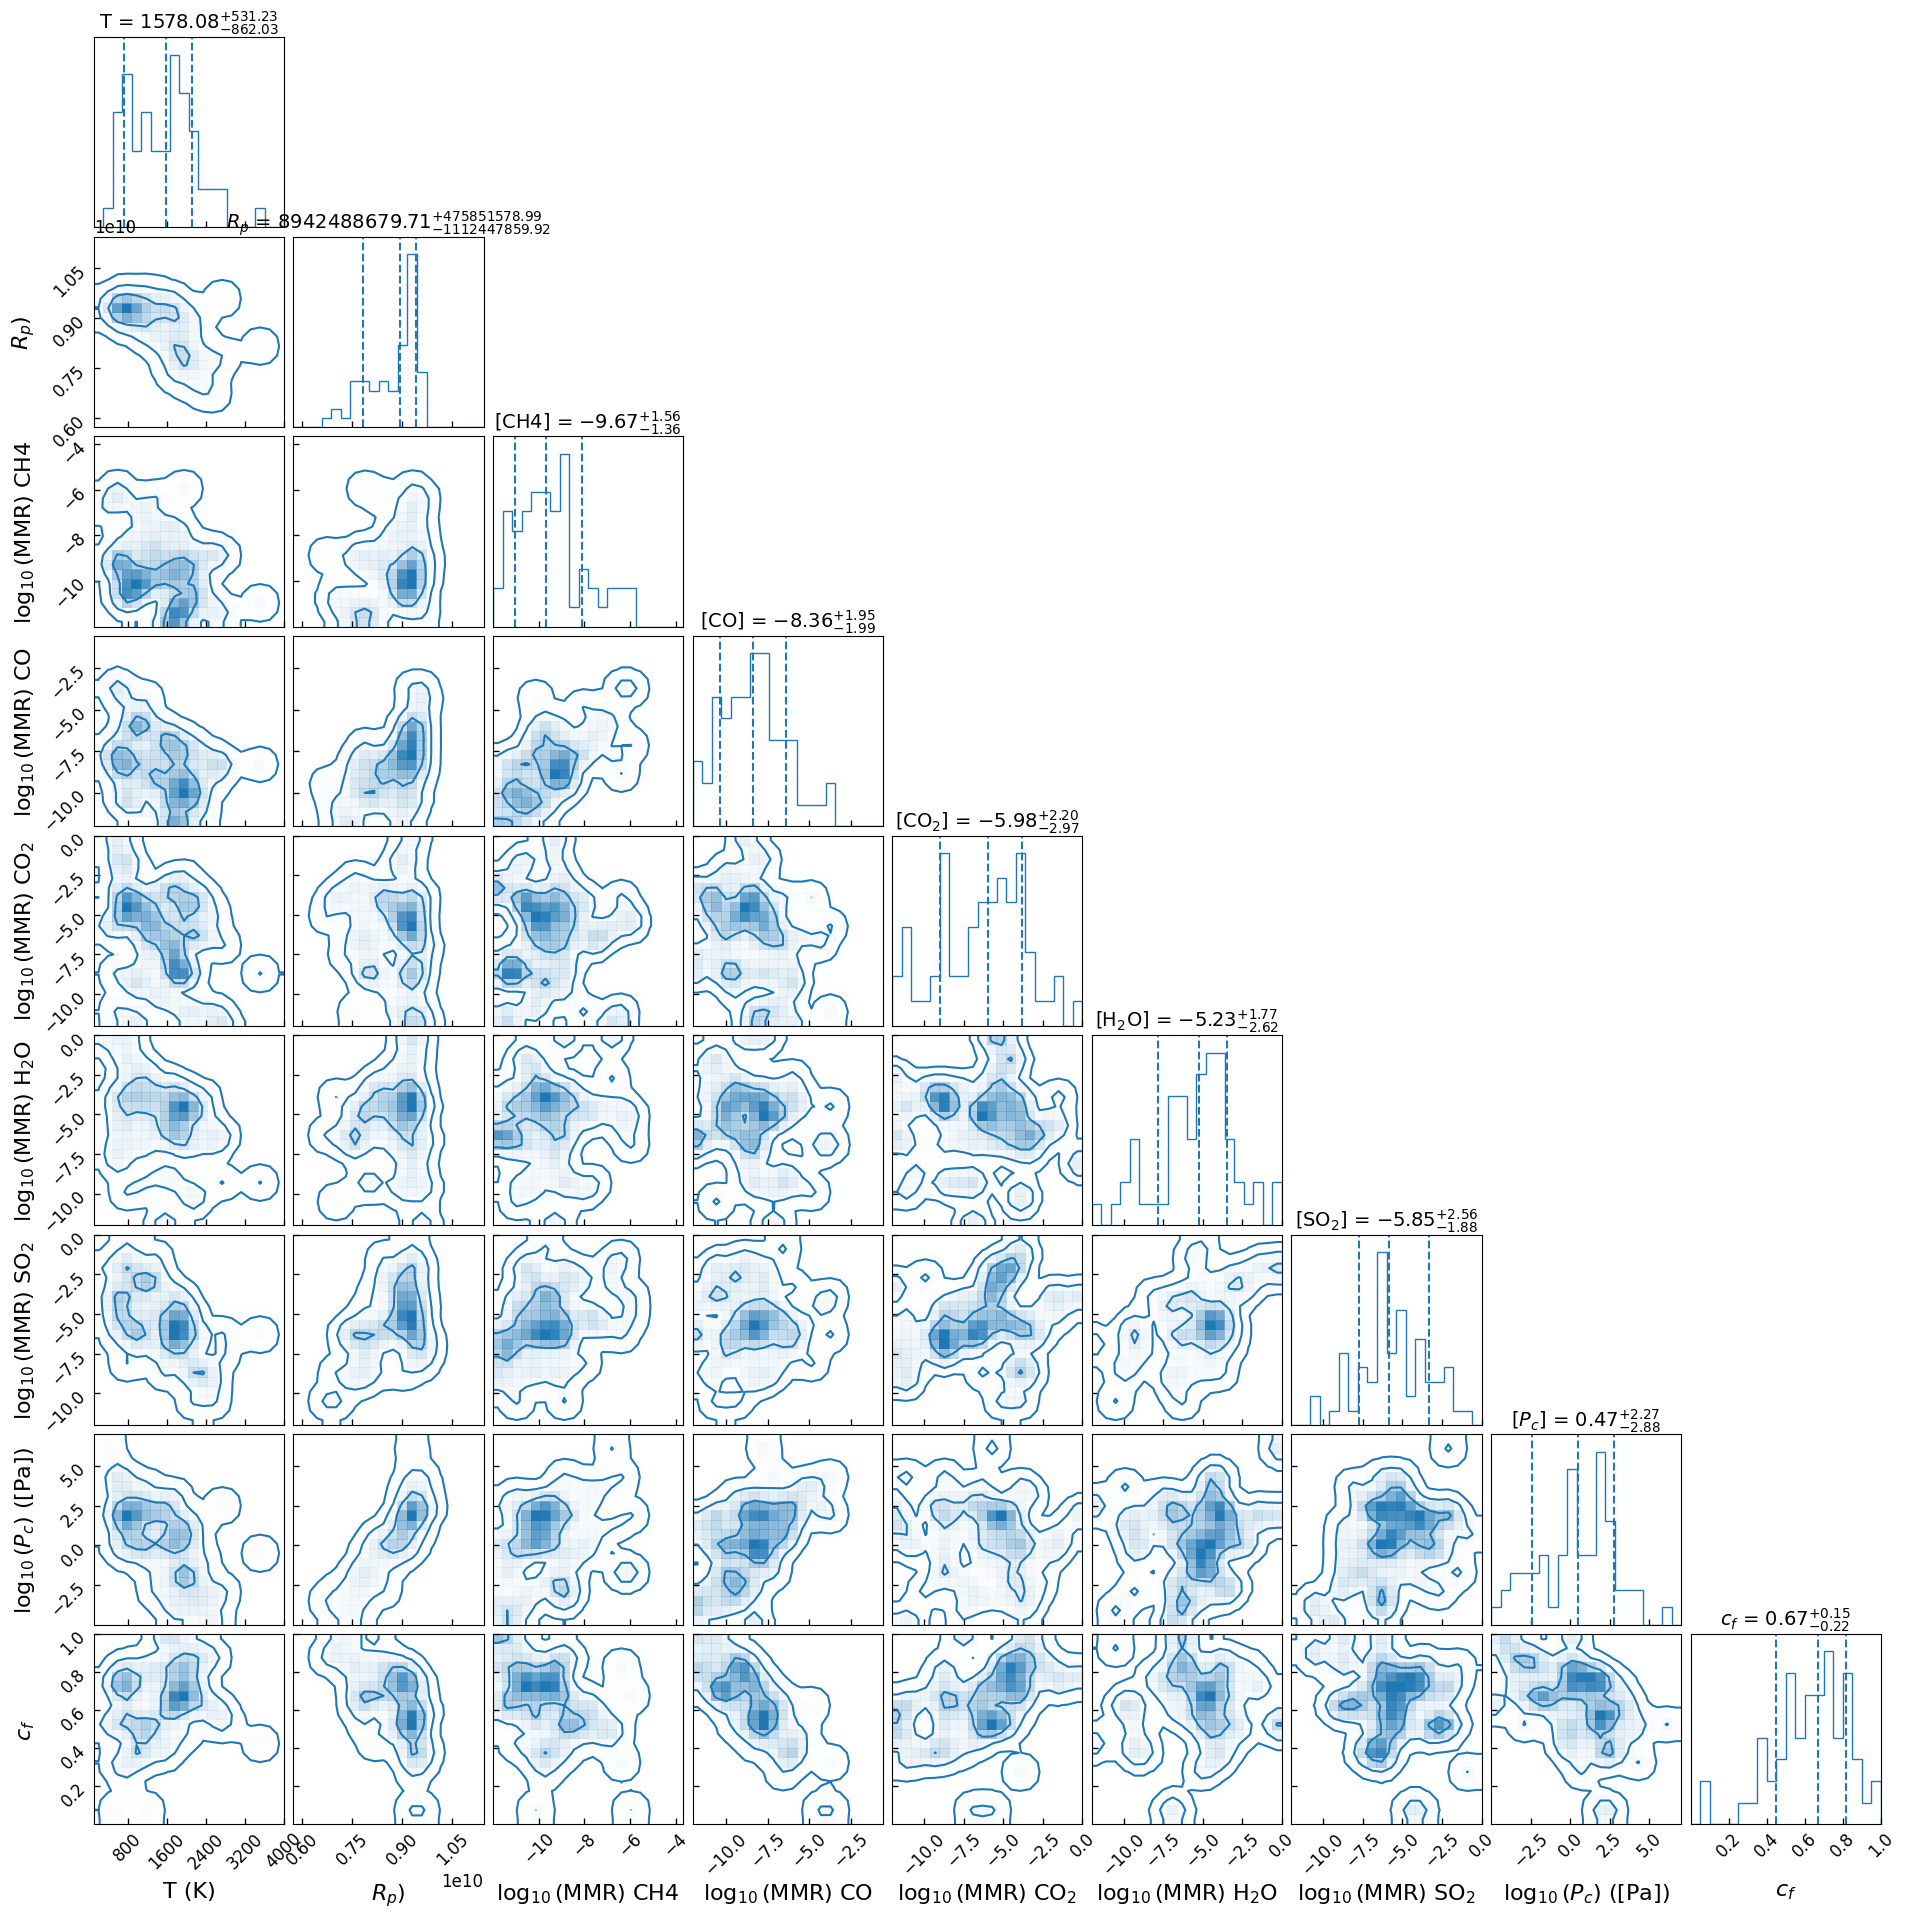

In [12]:
plot_result_corner(
    retrieval_directory=[
        retrieval_directory
    ],
    retrieved_parameters=retrieved_parameters,
    figure_name='corner_plot',
    label_kwargs={'fontsize': 16},
    title_kwargs={'fontsize': 14},
    figure_font_size=12,
    smooth=1,
    save=True, 
    figure_directory=retrieval_directory,  
    image_format='png'
)

## Best fit model and best fit parameters

We can obtain the best fit model (i.e., the model with the maximum log-likelihood) very easily with the `Retrieval.calculate_forward_model` function.

The fit may not seems very good, but remember that we multiplied the uncertainties by 20. Using the actual uncertainties, the fit would improve.

Text(0, 0.5, 'Residuals ($\\sigma$)')

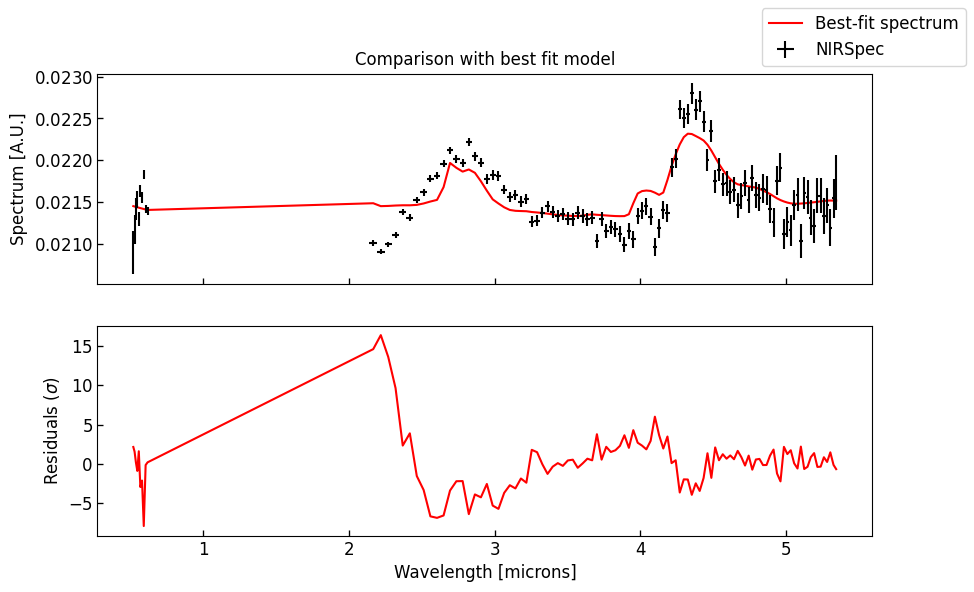

In [13]:
# Get the forward model with best-fit parameters
_, best_fit_spectra_nirspec, _ = retrieval.calculate_forward_model(
    parameters='best fit', 
    data='NIRSpec'
)

fig, axes = plt.subplots(nrows=2, sharex='all', figsize = (10,6))

axes[0].plot(nirspec_wavelengths, 1 - best_fit_spectra_nirspec[0, 0], ls='-', color='r', label='Best-fit spectrum')
axes[0].errorbar(nirspec_wavelengths, nirspec_data, xerr=nirspec_wavelength_bin_widths, yerr=nirspec_uncertainties, ls='', label='NIRSpec', color='k')

fig.legend()

axes[1].plot(nirspec_wavelengths, (1 - best_fit_spectra_nirspec[0, 0] - nirspec_data) / nirspec_uncertainties, ls='-', color='r')

axes[0].set_title(rf'Comparison with best fit model')
axes[0].set_ylabel('Spectrum [A.U.]')
axes[1].set_xlabel('Wavelength [microns]')
axes[1].set_ylabel(r'Residuals ($\sigma$)')

## Retrieval with multiple datasets

Let's now start an analysis with multiple datasets.

We also have data from 2 orders of the NIRISS SOSS instrument. Let's first load them.

In [14]:
niriss_data_file_1 = os.path.join(path_to_data, 'WASP39b_niriss_soss1.txt')
niriss_data_file_2 = os.path.join(path_to_data, 'WASP39b_niriss_soss2.txt')

niriss_wavelengths_1, niriss_wavelength_bin_widths_1, niriss_data_1, niriss_uncertainties_1 = np.loadtxt(niriss_data_file_1).T
niriss_wavelengths_2, niriss_wavelength_bin_widths_2, niriss_data_2, niriss_uncertainties_2 = np.loadtxt(niriss_data_file_2).T

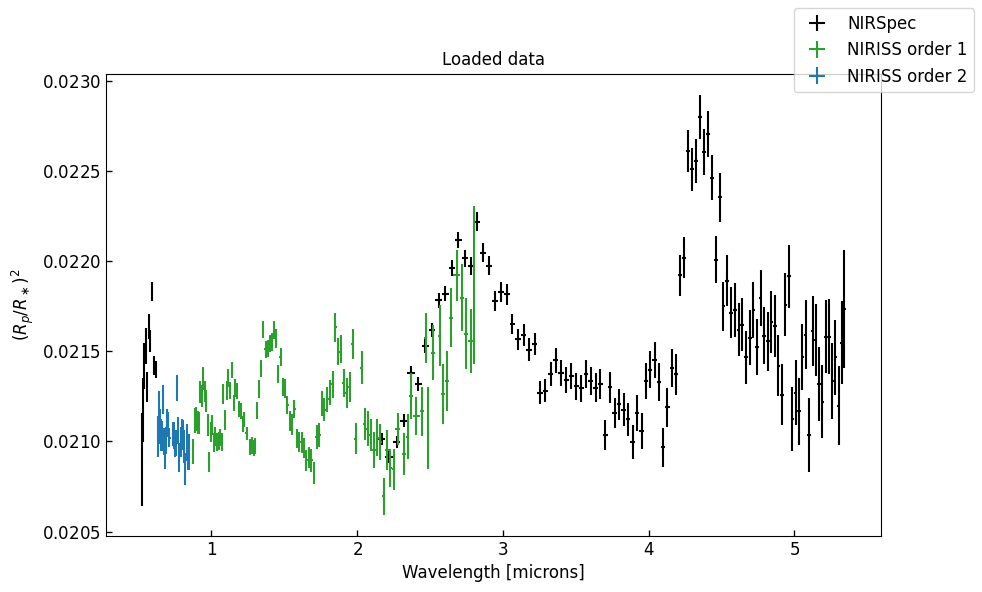

In [15]:
# Plot the data
fig, ax = plt.subplots(figsize = (10,6))

ax.errorbar(nirspec_wavelengths, nirspec_data, xerr=nirspec_wavelength_bin_widths, yerr=nirspec_uncertainties, ls='', color='k', label='NIRSpec')
ax.errorbar(niriss_wavelengths_1, niriss_data_1, xerr=niriss_wavelength_bin_widths_1, yerr=niriss_uncertainties_1, ls='', color='C2', label='NIRISS order 1')
ax.errorbar(niriss_wavelengths_2, niriss_data_2, xerr=niriss_wavelength_bin_widths_2, yerr=niriss_uncertainties_2, ls='', color='C0', label='NIRISS order 2')
ax.set_xlabel('Wavelength [microns]')
ax.set_ylabel(r'$(R_p/R_\ast)^2$')
ax.set_title('Loaded data')
fig.legend()

### Initializing forward models with shared properties

Now, let's make the forward models for the NIRISS data.

In these forward models, the **model parameters** are not different from those of the NIRSpec data, except for the wavelength range. We can thus make a copy, then modify the copy to implement the necessary changes.

In [16]:
niriss_1_model_parameters = copy.deepcopy(forward_model_nirspec.model_parameters)
niriss_1_model_parameters['rebinned_wavelengths'] = niriss_wavelengths_1 * 1e-4  # um to cm
niriss_1_model_parameters['bin_widths'] = niriss_wavelength_bin_widths_1 * 1e-4  # um to cm

niriss_2_model_parameters = copy.deepcopy(forward_model_nirspec.model_parameters)
niriss_2_model_parameters['rebinned_wavelengths'] = niriss_wavelengths_2 * 1e-4  # um to cm
niriss_2_model_parameters['bin_widths'] = niriss_wavelength_bin_widths_2 * 1e-4  # um to cm

We could instatiate two new fresh `SpectralModel` objects, but the NIRISS wavelength ranges appear to be included into the NIRSpec wavelength range. We can thus use the same opacities in the two spectra.

To do this, we can use the `from_radtrans` method to instantiate a new `SpectralModel`. In that case, opacities will be shared between the two forward models, without any additional memory cost.

<div class="alert alert-info">

Sharing opacities with several distinct `SpectralModel` objects without any memory cost is made possible by using `numpy` array [views](https://numpy.org/doc/stable/user/basics.copies.html).
</div>

<div class="alert alert-warning">

Sharing opacities saves memory, **but increases computation time** since the spectrum on the total wavelength range is calculated each time. Sharing opacities is thus **not always the best choice**. On a cluster, check how many processes you want to use and the available RAM. The choice to enable opacities sharing depends on if your retrieval is limited by RAM or processes. In this example, it would be more efficient to **not** share opacities. This is done here only to illustrate the possibility.
</div>

In [17]:
forward_model_niriss_1 = SpectralModel.from_radtrans(
    radtrans=forward_model_nirspec,
    **niriss_1_model_parameters
)

forward_model_niriss_2 = SpectralModel.from_radtrans(
    radtrans=forward_model_nirspec,
    **niriss_2_model_parameters
)

Loading Radtrans opacities...
Successfully loaded all opacities
Loading Radtrans opacities...
 Loading line opacities of species 'CH4.R300' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/CH4/12C-1H4/12C-1H4__YT34to10.R300_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CO-NatAbund.R300' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/CO/C-O-NatAbund/C-O-NatAbund__HITEMP.R300_0.1-250mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CO2.R300' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/CO2/12C-16O2/12C-16O2__UCL-4000.R300_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'H2O__POKAZATEL.R300' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/H2O/1H2-16O/1H2-16O__POKAZATEL.R300_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'SO2.R300' from file '/home/dblai

In [18]:
# Check the opacity sharing (note the use of "is" and not "==")
print(f"The NIRISS Order 1 forward model shares its opacities with the NIRSpec forward model:")

for species in forward_model_niriss_1.line_species:
    print(f" - {species}: {forward_model_niriss_1._lines_loaded_opacities['opacity_grid'][species] is forward_model_nirspec._lines_loaded_opacities['opacity_grid'][species]}")

print(f"The NIRISS Order 2 forward model shares its opacities with the NIRSpec forward model:")

for species in forward_model_niriss_2.line_species:
    print(f" - {species}: {forward_model_niriss_2._lines_loaded_opacities['opacity_grid'][species] is forward_model_nirspec._lines_loaded_opacities['opacity_grid'][species]}")

The NIRISS Order 1 forward model shares its opacities with the NIRSpec forward model:
 - CH4.R300: True
 - CO-NatAbund.R300: True
 - CO2.R300: True
 - H2O__POKAZATEL.R300: True
 - SO2.R300: True
The NIRISS Order 2 forward model shares its opacities with the NIRSpec forward model:
 - CH4.R300: True
 - CO-NatAbund.R300: True
 - CO2.R300: True
 - H2O__POKAZATEL.R300: True
 - SO2.R300: True


### Using special retrieved parameters

Since we have three datasets, we can use the **special parameter** `_spectrum_offset` to offsets to spectra, so that imprecisions in the different instrumental fluxes can be adjusted for.

Special parameters are used to modify the forward model or the uncertainties during a retrieval. There are 3 of them:

- `_spectrum_offset`: add a float to the forward model's spectrum.
- `_spectrum_scaling`: multiply the forward model's spectrum by a float.
- `_uncertainty_scaling`: multiply or add a float to the data uncertainties, depending on the value of `retrieval.uncertainties_mode`.

This latter attribute can be `default` (do not change the uncertainties), `optimize` (automatically optimize for uncertainties, following [Gibson et al. 2020](https://doi.org/10.1093/mnras/staa228), `retrieve` (multiply), or `retrieve_add` (add).

Special parameters support name variations (e.g. `_spectrum_offset_niriss_1` is treated the same as `_spectrum_offset`) and the log10 parameter name rules (e.g. `_log10_spectrum_offset`).

<div class="alert alert-warning">
    
Retrieving or optimizing for the data uncertainties should be done with **extreme caution**. This makes the **very strong** assumption that your forward model **must** be correct (and that the estimation of the uncertainties may be incorrect). This will "force" the goodness of fit ($\chi^2$) to be close to 1, preventing the diagnosis of an under- or overfit of the data. Be sure to have a solid justifaction for using this mode.
</div>

Let's add two new offsets to the retrieved parameters. We will use Gaussian priors since we estimate that large offset errors are less likely than small ones.

In [19]:
retrieved_parameters.update({
    '_spectrum_offset_niriss_1': {
        'prior_parameters': [0, 1e-4],  # gaussian prior: mean, standard deviation
        'prior_type': 'gaussian',
        'figure_title': r'Offset 1',
        'figure_label': r'Offset NIRISS 1'
    },
    '_spectrum_offset_niriss_2': {
        'prior_parameters': [0, 1e-4],  # gaussian prior: mean, standard deviation
        'prior_type': 'gaussian',
        'figure_title': r'Offset 2',
        'figure_label': r'Offset NIRISS 2'
    }
})

We then need to indicate which forward models these offsets must **not** be applied to. This can be done by using the `fixed_special_parameters` argument when instantiating our `Data` objects:

In [20]:
data = {
    'NIRSpec': forward_model_nirspec.init_data(
        # Data parameters
        data_spectrum=1 - nirspec_data,  # SpectralModel scale spectra using 1 - R_p/R_*
        data_wavelengths=nirspec_wavelengths,
        data_uncertainties=nirspec_uncertainties * 20,  # ⚠️ uncertainties artificially multiplied by 20 to speed up the retrieval in this example
        data_name='NIRSpec',
        # Retrieved parameters
        retrieved_parameters=retrieved_parameters,
        fixed_special_parameters={
            '_spectrum_offset_niriss_1': 0.0,
            '_spectrum_offset_niriss_2': 0.0
        },
        # Forward model post-processing parameters
        mode='transmission',
        scale=True,
        convolve=True,
        rebin=True
    ),
    'NIRISS1': forward_model_niriss_1.init_data(
        # Data parameters
        data_spectrum=1 - niriss_data_1,  # SpectralModel scale spectra using 1 - R_p/R_*
        data_wavelengths=niriss_wavelengths_1,
        data_uncertainties=niriss_uncertainties_1 * 20,  # ⚠️ uncertainties artificially multiplied by 20 to speed up the retrieval in this example
        data_name='NIRISS1',
        # Retrieved parameters
        retrieved_parameters=retrieved_parameters,
        fixed_special_parameters={
            '_spectrum_offset_niriss_2': 0.0
        },
        # Forward model post-processing parameters
        mode='transmission',
        scale=True,
        convolve=True,
        rebin=True
    ),
    'NIRISS2': forward_model_niriss_2.init_data(
        # Data parameters
        data_spectrum=1 - niriss_data_2,  # SpectralModel scale spectra using 1 - R_p/R_*
        data_wavelengths=niriss_wavelengths_2,
        data_uncertainties=niriss_uncertainties_2 * 20,  # ⚠️ uncertainties artificially multiplied by 20 to speed up the retrieval in this example
        data_name='NIRISS2',
        # Retrieved parameters
        retrieved_parameters=retrieved_parameters,
        fixed_special_parameters={
            '_spectrum_offset_niriss_1': 0.0
        },
        # Forward model post-processing parameters
        mode='transmission',
        scale=True,
        convolve=True,
        rebin=True
    )
}

### Running the retrieval

With multiple datasets, the retrieval is instantiated an run in the same way as with one dataset.

In [21]:
retrieval_name = 'spectral_model_jwst_example_3_datasets'
retrieval_directory = os.path.join('.', 'results', retrieval_name)

retrieval = Retrieval.from_data(
    data=data,
    retrieved_parameters=retrieved_parameters,
    retrieval_name=retrieval_name,
    output_directory=retrieval_directory,
    run_mode='retrieval'
)

Using provided Radtrans object for data 'NIRSpec'...
Using provided Radtrans object for data 'NIRISS1'...
Using provided Radtrans object for data 'NIRISS2'...


Let's now run the retrieval. It should take about 1 hour with 15 processes.

In [22]:
run_retrieval = False

In [23]:
%%time
if run_retrieval:
    retrieval.run(
        n_live_points=15,
        resume=False,
        max_iters=30,
        n_iter_before_update=1,
        seed=12345  # ⚠️ seed should be removed or set to -1 in a real retrieval, it is added here for reproducibility
    )

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 5.48 µs


### Plotting

We can plot the retrieval results just as before.

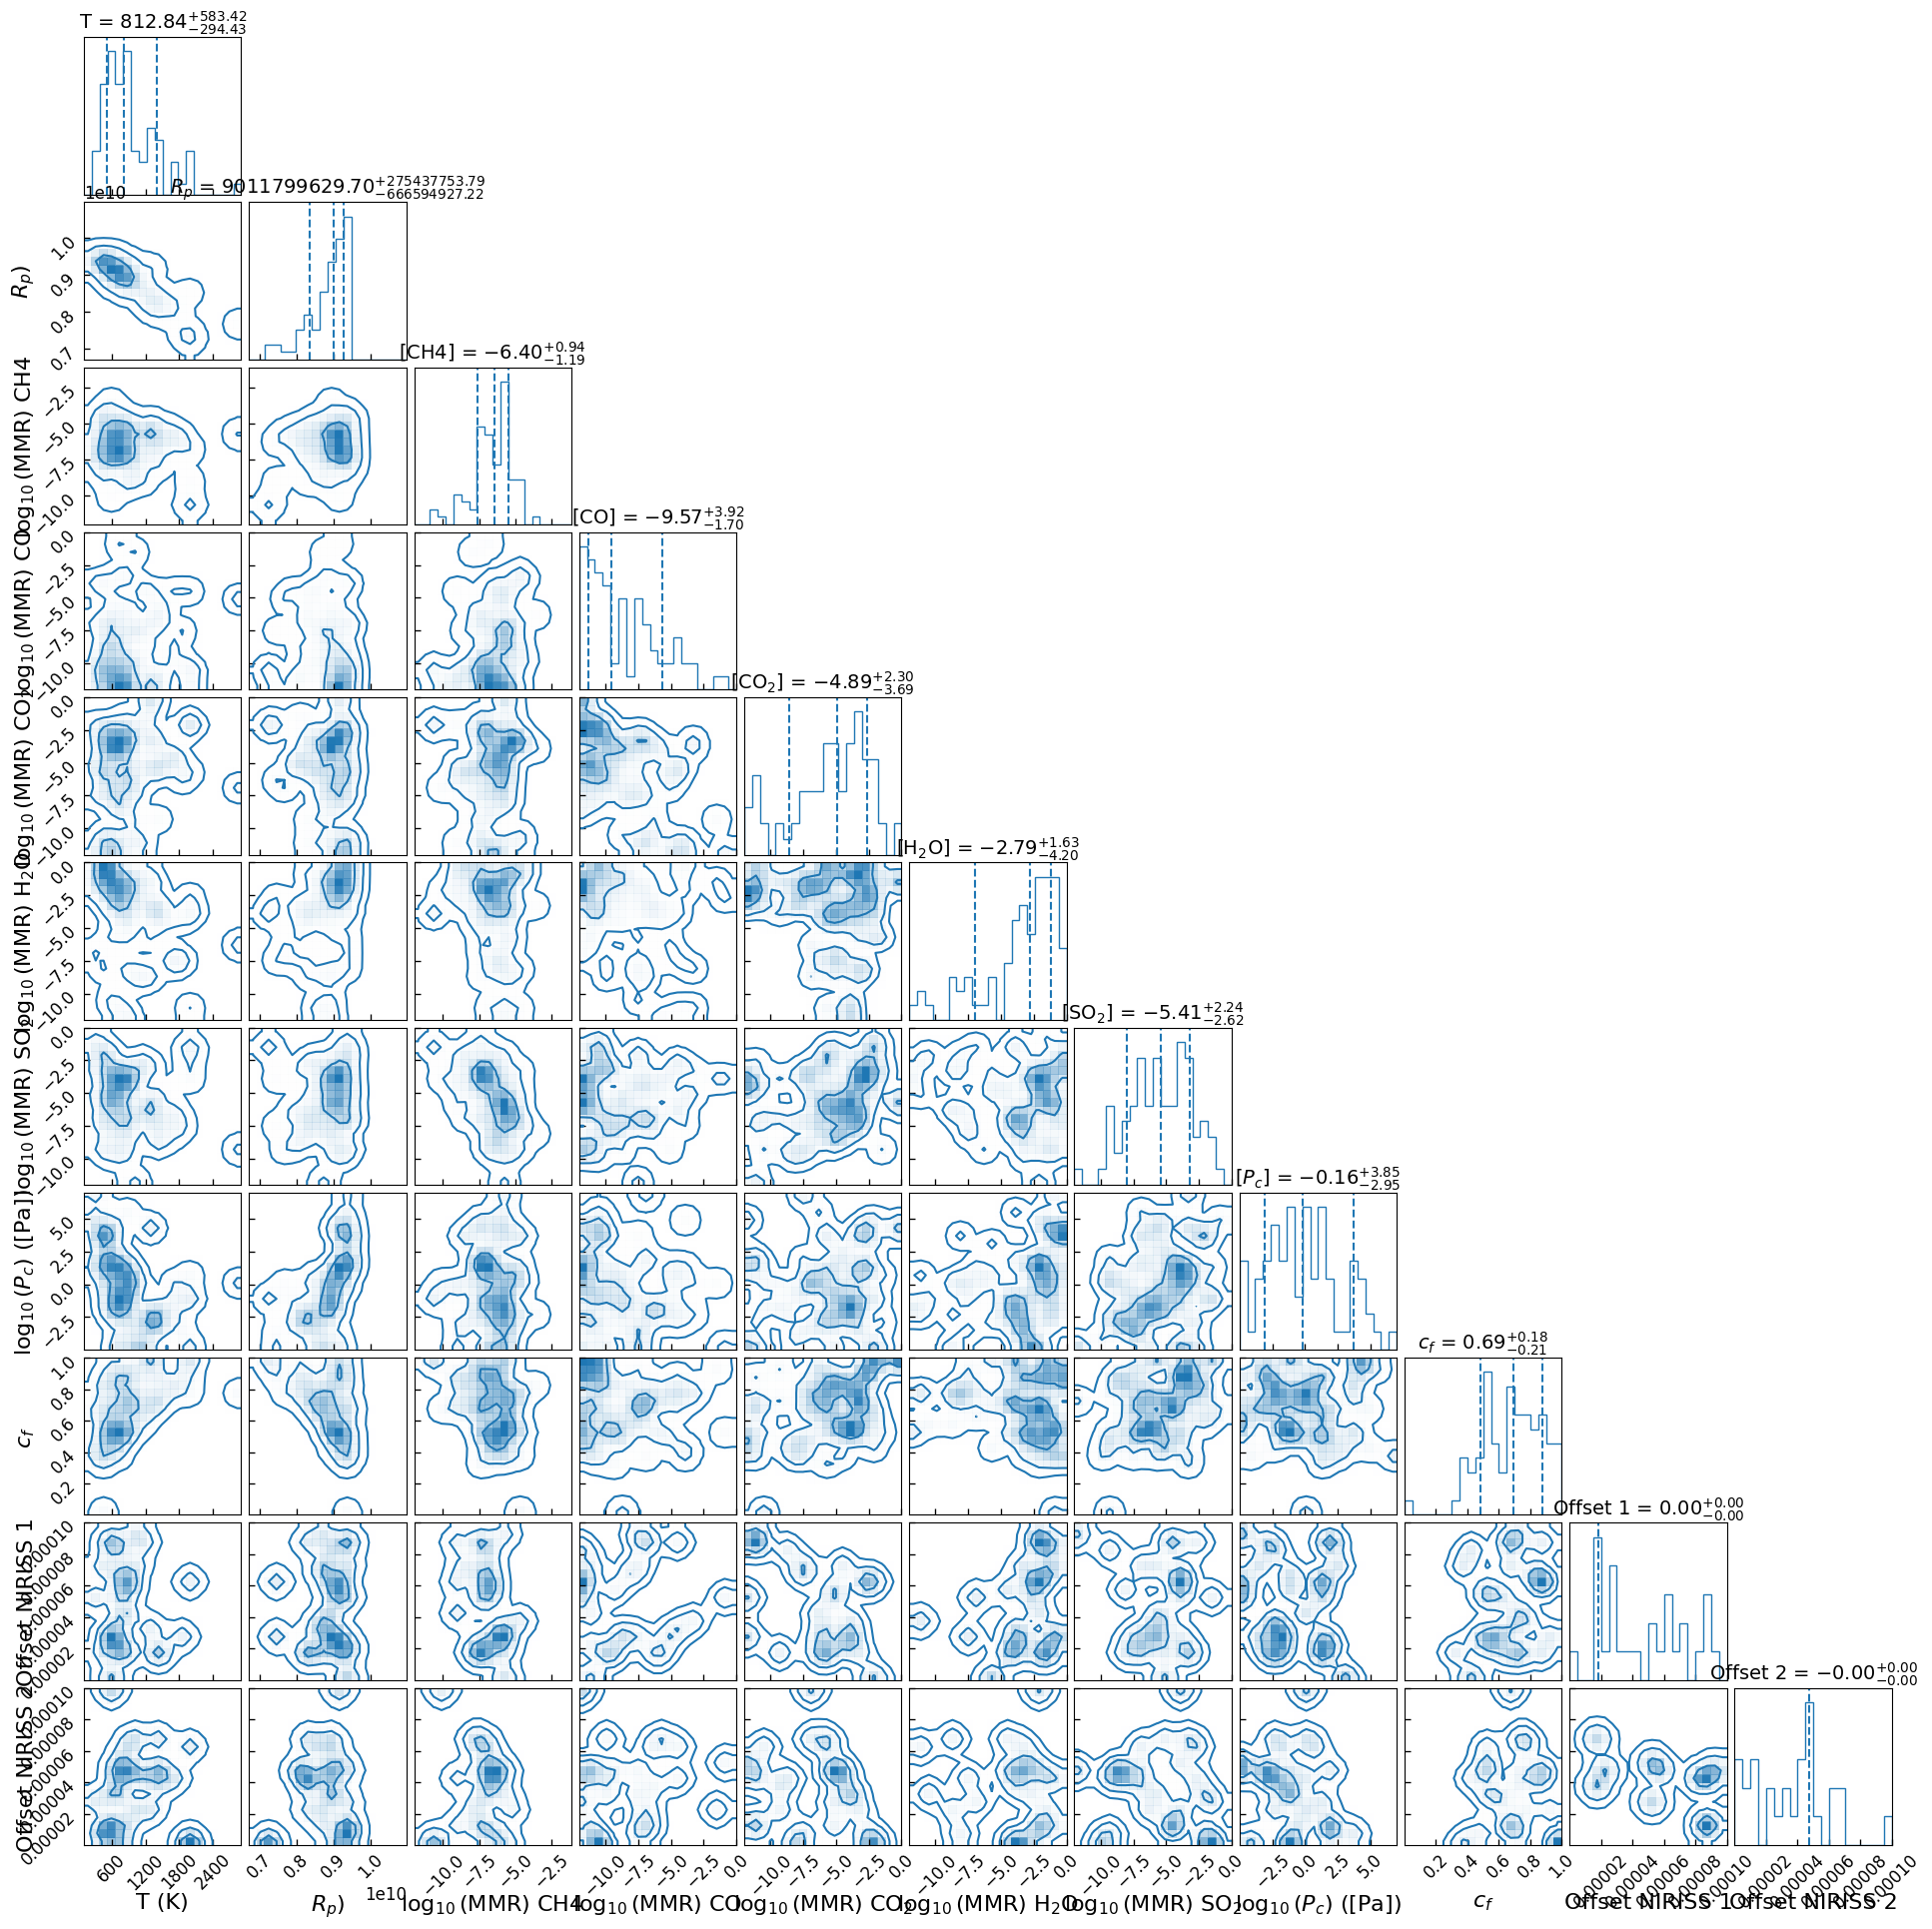

In [24]:
plot_result_corner(
    retrieval_directory=[
        retrieval_directory
    ],
    retrieved_parameters=retrieved_parameters,
    figure_name='corner_plot',
    label_kwargs={'fontsize': 16},
    title_kwargs={'fontsize': 14},
    figure_font_size=12,
    smooth=1,
    save=True, 
    figure_directory=retrieval_directory,  
    image_format='png'
)

We can display the best fit parameters as follows:

In [25]:
best_fit_parameters, max_likelihood, chi2 = retrieval.get_best_fit_parameters(return_max_likelihood=True)
data_size = nirspec_data.size + niriss_data_1.size + niriss_data_2.size

chi2 *= 20

print(f"Best fit reduced chi2 against the data with 20 times uncertainties: {chi2 / (data_size - len(retrieved_parameters)):.2e} (from Log(L)/20 = {max_likelihood:.2f})")

print("\nBest fit parameters:")

for parameter_name, value in best_fit_parameters.items():
    print(f"    - '{parameter_name}': {value:.5f}")

Best fit reduced chi2 against the data with 20 times uncertainties: 3.61e-01 (from Log(L)/20 = -2.13)

Best fit parameters:
    - 'temperature': 816.21423
    - 'planet_radius': 9084383263.37268
    - 'CH4.R300': -6.97705
    - 'CO-NatAbund.R300': -11.74750
    - 'CO2.R300': -2.59256
    - 'H2O__POKAZATEL.R300': -2.23213
    - 'SO2.R300': -4.03252
    - 'log10_opaque_cloud_top_pressure': -3.62158
    - 'cloud_fraction': 0.89951
    - '_spectrum_offset_niriss_1': 0.00006
    - '_spectrum_offset_niriss_2': -0.00014


Let's now plot the best fit models.

It seems that here, the fit on the NIRISS order 1 is not very good. However, keep in mind that here we multiplied the uncertainties by 20, relaxing the fitting constraints. Using the actual uncertainties, the fit would improve.

Text(0, 0.5, 'Residuals ($\\sigma$)')

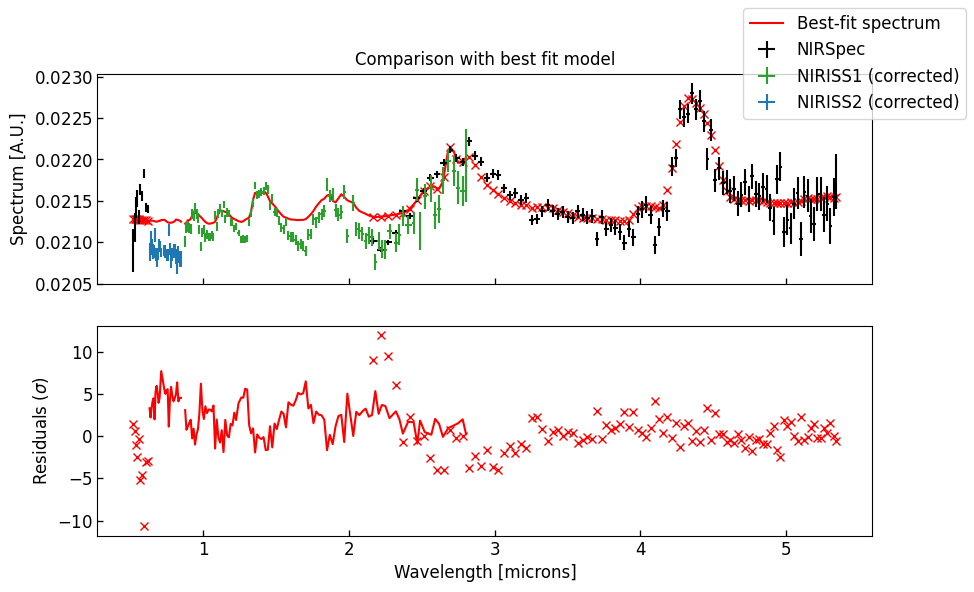

In [26]:
# Get the forward model with best-fit parameters
_, best_fit_spectra_nirspec, _ = retrieval.calculate_forward_model(
    parameters='best fit', 
    data='NIRSpec'
)
_, best_fit_spectra_niriss_1, _ = retrieval.calculate_forward_model(
    parameters='best fit', 
    data='NIRISS1'
)
_, best_fit_spectra_niriss_2, _ = retrieval.calculate_forward_model(
    parameters='best fit', 
    data='NIRISS2'
)

# Remove the offsets from the models
best_fit_spectra_niriss_1 -= best_fit_parameters['_spectrum_offset_niriss_1']
best_fit_spectra_niriss_2 -= best_fit_parameters['_spectrum_offset_niriss_2']

# Apply the offsets on the data
corrected_niriss_data_1 = niriss_data_1 + best_fit_parameters['_spectrum_offset_niriss_1']
corrected_niriss_data_2 = niriss_data_2 + best_fit_parameters['_spectrum_offset_niriss_2']

# Plot the fits
fig, axes = plt.subplots(nrows=2, sharex='all', figsize = (10,6))

axes[0].plot(nirspec_wavelengths, 1 - best_fit_spectra_nirspec[0, 0], ls='', marker='x', color='r')
axes[0].plot(niriss_wavelengths_1, 1 - best_fit_spectra_niriss_1[0, 0], ls='-', marker='', color='r')
axes[0].plot(niriss_wavelengths_2, 1 - best_fit_spectra_niriss_2[0, 0], ls='-', marker='', color='r', label='Best-fit spectrum')
axes[0].errorbar(nirspec_wavelengths, nirspec_data, xerr=nirspec_wavelength_bin_widths, yerr=nirspec_uncertainties, ls='', label='NIRSpec', color='k')
axes[0].errorbar(niriss_wavelengths_1, corrected_niriss_data_1, xerr=niriss_wavelength_bin_widths_1, yerr=niriss_uncertainties_1, ls='', color='C2', label='NIRISS1 (corrected)')
axes[0].errorbar(niriss_wavelengths_2, corrected_niriss_data_2, xerr=niriss_wavelength_bin_widths_2, yerr=niriss_uncertainties_2, ls='', color='C0', label='NIRISS2 (corrected)')

fig.legend()

axes[1].plot(nirspec_wavelengths, (1 - best_fit_spectra_nirspec[0, 0] - nirspec_data) / nirspec_uncertainties, ls='', marker='x', color='r')
axes[1].plot(niriss_wavelengths_1, (1 - best_fit_spectra_niriss_1[0, 0] - corrected_niriss_data_1) / niriss_uncertainties_1, ls='-', color='r')
axes[1].plot(niriss_wavelengths_2, (1 - best_fit_spectra_niriss_2[0, 0] - corrected_niriss_data_2) / niriss_uncertainties_2, ls='-', color='r')

axes[0].set_title(rf'Comparison with best fit model')
axes[0].set_ylabel('Spectrum [A.U.]')
axes[1].set_xlabel('Wavelength [microns]')
axes[1].set_ylabel(r'Residuals ($\sigma$)')

### Offsets effect on the models

We can check that the offsets work as expected.

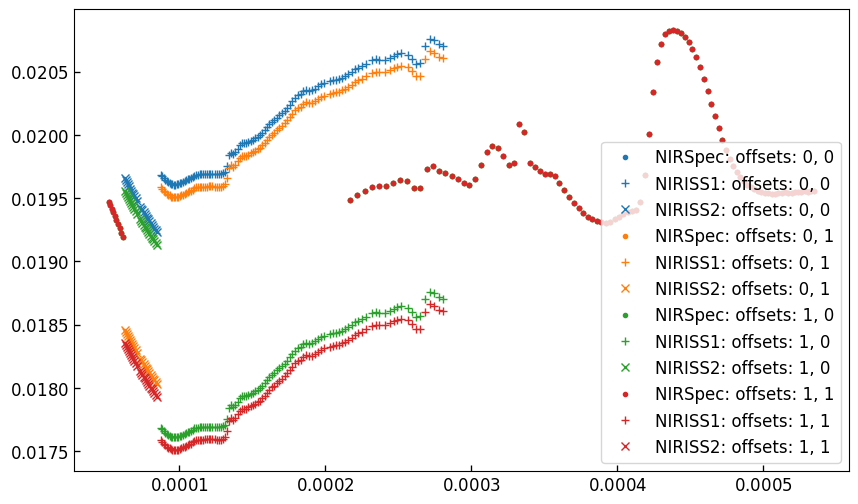

In [27]:
# Get the mid allowed value of the retrieval parameters
mid_range_parameters = retrieval.get_parameters_prior_mid_range_values()

# Plot the figure
fig, ax = plt.subplots(figsize=(10, 6))

color_id = 0

for i, offset1 in enumerate(np.linspace(-0.001, 0.001, 2)):
    for j, offset2 in enumerate(np.linspace(-0.0005, 0.0007, 2)):
        offset1 += 1e-4 * j  # add a small offset for the second pass for visualization
        offset2 += 1e-4 * i  # add a small offset for the second pass for visualization

        # Change the offsets values in the parameters list
        mid_range_parameters[-2] = offset1
        mid_range_parameters[-1] = offset2

        # Plot the spectra of each forward model with the mid allowed value of the retrieval parameters, and varying offsets
        wavelengths_nirspec, spectrum_nirspec, _ = retrieval.calculate_forward_model(
            parameters=mid_range_parameters,
            data='NIRSpec'
        )
        wavelengths_niriss_1, spectrum_niriss_1, _ = retrieval.calculate_forward_model(
            parameters=mid_range_parameters,
            data='NIRISS1'
        )
        wavelengths_niriss_2, spectrum_niriss_2, _ = retrieval.calculate_forward_model(
            parameters=mid_range_parameters,
            data='NIRISS2'
        )

        ax.plot(wavelengths_nirspec[0], 1 - spectrum_nirspec[0, 0], color=f"C{color_id}", ls='', marker='.', label=f"NIRSpec: offsets: {i}, {j}")
        ax.plot(wavelengths_niriss_1[0], 1 - spectrum_niriss_1[0, 0], color=f"C{color_id}", ls='', marker='+', label=f"NIRISS1: offsets: {i}, {j}")
        ax.plot(wavelengths_niriss_2[0], 1 -spectrum_niriss_2[0, 0], color=f"C{color_id}", ls='', marker='x', label=f"NIRISS2: offsets: {i}, {j}")

        color_id += 1

ax.legend()